# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [ ]:
# imports
import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [2]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [3]:
# NLP related imports
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [4]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [6]:
load_dotenv(override=True)

True

In [7]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [8]:
from items import Item

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files

If you didn't already create these in Day 2, you can also download them from my google drive (you'll also find the slides here):  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

But note that the files are quite large - you might need to get a coffee!

In [9]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [10]:
# Remind ourselves the training prompt

print(train[0].prompt)

How much does this cost to the nearest dollar?

Pacific Digital 4X External USB Dual Format DVD Drive
Product Description Burn your own CDs and DVDs or back up important files with ease using this Pacific Digital 4x Dual Format External DVD Burner. The full-featured software makes this one of the most versatile and universally compatible burners available. Features portable external design; back up from multiple systems; DVD+R/-RW, DVD-R/-RW, and CD-R/RW compatible; easily connects to PC or notebook; enough storage for more than 3,000 pictures; software for creating your own DVD movies or music CDs; and it works as a full-featured DVD player. From the Manufacturer Capture, Create, Convert, Watch. DVD+R/+RW, DVD-R/-RW and CD-R/RW recording together with a full

Price is $199.00


In [11]:
# Remind a test prompt

print(train[0].price)

199.0


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [12]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [13]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $51.18 Error: $603.82 SLE: 6.41 Item: Nadair 22" LED Under Cabinet Lighting Ki...
2: Guess: $115.00 Truth: $319.99 Error: $204.99 SLE: 1.04 Item: Touch of Class Piala Pineapple Table Lam...
3: Guess: $26.00 Truth: $137.54 Error: $111.54 SLE: 2.67 Item: Legrand - OnQ Desk Mount Power Supply, P...
4: Guess: $760.00 Truth: $470.33 Error: $289.67 SLE: 0.23 Item: Moen TS44503BG Colinet Two Deck-Mount Ro...
5: Guess: $282.00 Truth: $57.97 Error: $224.03 SLE: 2.46 Item: ShowerMaxx, Elite Series, 6 Spray Settin...
6: Guess: $251.00 Truth: $28.77 Error: $222.23 SLE: 4.56 Item: Cenipar WD08X10057 Dishwasher Door Gaske...
7: Guess: $229.00 Truth: $14.90 Error: $214.10 SLE: 7.14 Item: Belkin 15.4-Inch Neoprene Sleeve (Black/...
8: Guess: $143.00 Truth: $224.00 Error: $81.00 SLE: 0.20 Item: TOTO UT447E#01 Commercial Washout Urinal...
9: Guess: $755.00 Truth: $29.00 Error: $726.00 SLE: 10.41 Item: DC Programmable Meter Controller 0-200V ...
10: Guess: $105.00 Truth: $144.08 

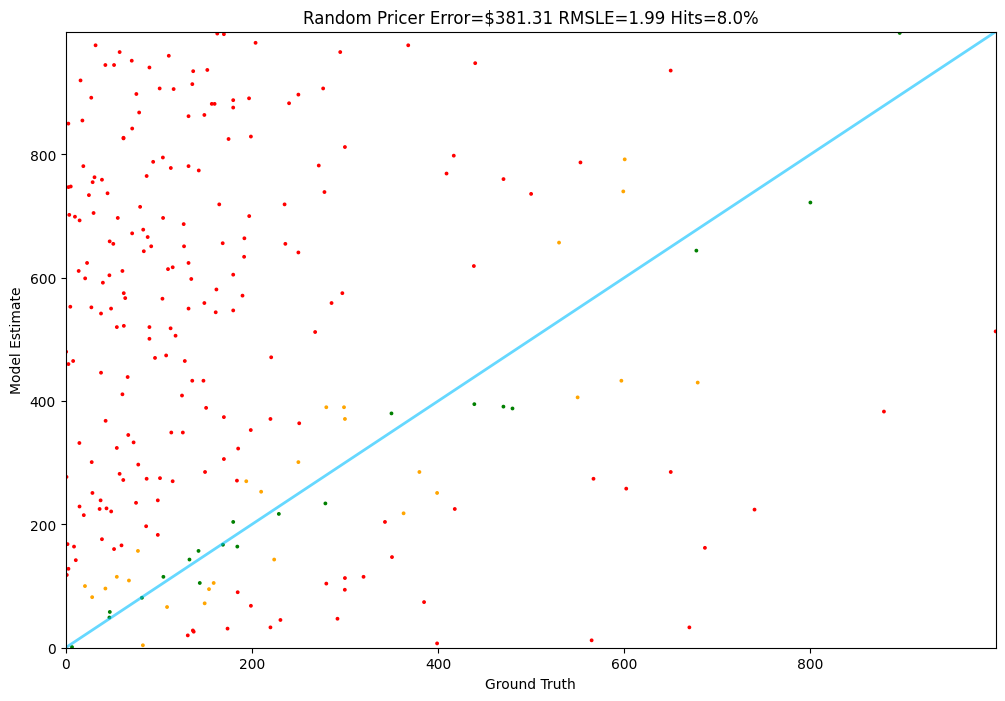

In [14]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [15]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $183.44 Truth: $51.18 Error: $132.26 SLE: 1.59 Item: Nadair 22" LED Under Cabinet Lighting Ki...
2: Guess: $183.44 Truth: $319.99 Error: $136.55 SLE: 0.31 Item: Touch of Class Piala Pineapple Table Lam...
3: Guess: $183.44 Truth: $137.54 Error: $45.90 SLE: 0.08 Item: Legrand - OnQ Desk Mount Power Supply, P...
4: Guess: $183.44 Truth: $470.33 Error: $286.89 SLE: 0.88 Item: Moen TS44503BG Colinet Two Deck-Mount Ro...
5: Guess: $183.44 Truth: $57.97 Error: $125.47 SLE: 1.30 Item: ShowerMaxx, Elite Series, 6 Spray Settin...
6: Guess: $183.44 Truth: $28.77 Error: $154.67 SLE: 3.33 Item: Cenipar WD08X10057 Dishwasher Door Gaske...
7: Guess: $183.44 Truth: $14.90 Error: $168.54 SLE: 6.01 Item: Belkin 15.4-Inch Neoprene Sleeve (Black/...
8: Guess: $183.44 Truth: $224.00 Error: $40.56 SLE: 0.04 Item: TOTO UT447E#01 Commercial Washout Urinal...
9: Guess: $183.44 Truth: $29.00 Error: $154.44 SLE: 3.30 Item: DC Programmable Meter Controller 0-200V ...
10: Guess: $183.44 Truth: $144.08 E

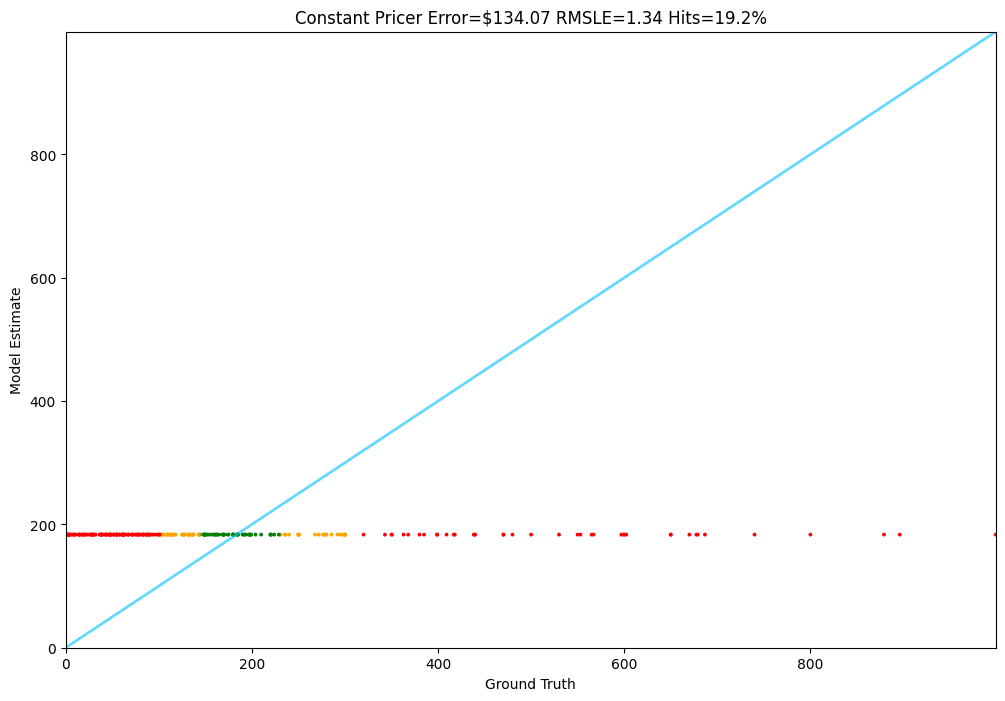

In [16]:
# Run our constant predictor
Tester.test(constant_pricer)

### Retreive some feature and check 

In [17]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

In [18]:
train[0].features.keys()

dict_keys(['Package Dimensions', 'Item Weight', 'Item model number', 'Date First Available', 'Manufacturer'])

In [19]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 245258),
 ('Manufacturer', 226071),
 ('Item Weight', 224603),
 ('Brand', 218519),
 ('Best Sellers Rank', 212625),
 ('Item model number', 190219),
 ('Product Dimensions', 177442),
 ('Color', 156902),
 ('Is Discontinued By Manufacturer', 114215),
 ('Material', 111551),
 ('Batteries Required?', 90978),
 ('Part Number', 89200),
 ('Country of Origin', 76153),
 ('Special Feature', 75269),
 ('Included Components', 72882),
 ('Style', 71748),
 ('Batteries Included?', 70834),
 ('Item Package Quantity', 68320),
 ('Size', 55969),
 ('Power Source', 54356),
 ('Package Dimensions', 50164),
 ('Finish Type', 48893),
 ('Voltage', 45931),
 ('Item Dimensions LxWxH', 43647),
 ('Mounting Type', 39692),
 ('Special Features', 39001),
 ('Shape', 38982),
 ('Finish', 38782),
 ('Number of Items', 36378),
 ('Model Name', 34484),
 ('Compatible Devices', 32064),
 ('Connectivity Technology', 32023),
 ('Wattage', 31409),
 ('Warranty Description', 30275),
 ('Batteries', 25846),
 ('Room Type', 

In [20]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [21]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [22]:
average_weight = sum(weights)/len(weights)
average_weight

8.721770381880027

In [23]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [24]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [25]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

197573.9801420303

In [26]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [27]:
def get_text_length(item):
    return len(item.test_prompt())

In [28]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 5803),
 ('Dell', 3463),
 ('Lenovo', 2526),
 ('ASUS', 1476),
 ('Sony', 1406),
 ('Canon', 1338),
 ('SAMSUNG', 1329),
 ('Kohler', 1255),
 ('Kingston Brass', 975),
 ('Moen', 967),
 ('DELTA FAUCET', 920),
 ('Apple', 739),
 ('DEWALT', 729),
 ('Generic', 704),
 ('Intel', 692),
 ('Panasonic', 660),
 ('Filterbuy', 633),
 ('Makita', 624),
 ('Milwaukee', 609),
 ('Kichler', 606),
 ('Brother', 551),
 ('Nikon', 547),
 ('Progress Lighting', 533),
 ('Garmin', 531),
 ('American Standard', 489),
 ('MSI', 478),
 ('Epson', 473),
 ('GODOX', 469),
 ('Microsoft', 458),
 ('Cosmas', 449),
 ('BOSCH', 443),
 ('Pyle', 407),
 ('Acer', 396),
 ('Hunter Fan Company', 393),
 ('Aviditi', 383),
 ('Livex Lighting', 382),
 ('Logitech', 381),
 ('LG', 380),
 ('Safavieh', 374),
 ('3M', 360)]

In [29]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [30]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [31]:
# Look at features in a training item
get_features(train[0])

{'weight': 5.75,
 'rank': 197573.9801420303,
 'text_length': 781,
 'is_top_electronics_brand': 0}

In [32]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [33]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.7991085005145437
rank: 4.01412156533449e-05
text_length: -0.01061980679289529
is_top_electronics_brand: 210.75506952766023
Intercept: 161.2915492358487
Mean Squared Error: 31358.38122114624
R-squared Score: 0.08284201980412786


In [34]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $168.57 Truth: $51.18 Error: $117.39 SLE: 1.39 Item: Nadair 22" LED Under Cabinet Lighting Ki...
2: Guess: $168.17 Truth: $319.99 Error: $151.82 SLE: 0.41 Item: Touch of Class Piala Pineapple Table Lam...
3: Guess: $155.51 Truth: $137.54 Error: $17.97 SLE: 0.01 Item: Legrand - OnQ Desk Mount Power Supply, P...
4: Guess: $163.72 Truth: $470.33 Error: $306.61 SLE: 1.11 Item: Moen TS44503BG Colinet Two Deck-Mount Ro...
5: Guess: $162.72 Truth: $57.97 Error: $104.75 SLE: 1.04 Item: ShowerMaxx, Elite Series, 6 Spray Settin...
6: Guess: $168.28 Truth: $28.77 Error: $139.51 SLE: 3.02 Item: Cenipar WD08X10057 Dishwasher Door Gaske...
7: Guess: $160.84 Truth: $14.90 Error: $145.94 SLE: 5.38 Item: Belkin 15.4-Inch Neoprene Sleeve (Black/...
8: Guess: $205.72 Truth: $224.00 Error: $18.28 SLE: 0.01 Item: TOTO UT447E#01 Commercial Washout Urinal...
9: Guess: $158.93 Truth: $29.00 Error: $129.93 SLE: 2.80 Item: DC Programmable Meter Controller 0-200V ...
10: Guess: $167.82 Truth: $144.08 E

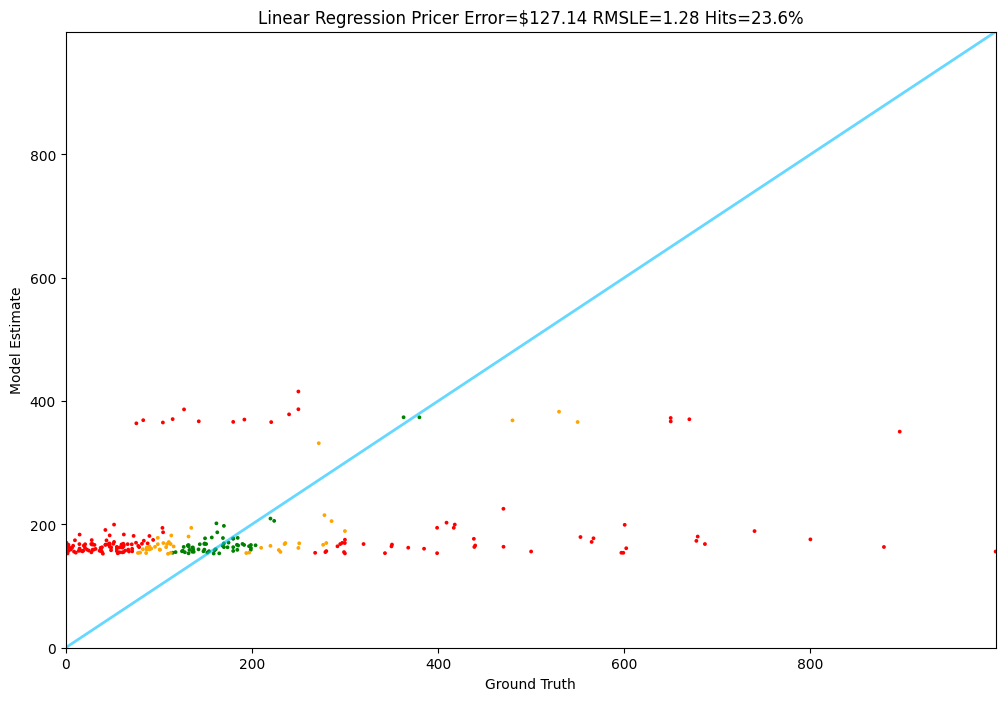

In [35]:
# test it

Tester.test(linear_regression_pricer)

In [36]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

# word2vec

In [37]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [38]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $147.57 Truth: $51.18 Error: $96.39 SLE: 1.09 Item: Nadair 22" LED Under Cabinet Lighting Ki...
2: Guess: $146.62 Truth: $319.99 Error: $173.37 SLE: 0.60 Item: Touch of Class Piala Pineapple Table Lam...
3: Guess: $190.64 Truth: $137.54 Error: $53.10 SLE: 0.11 Item: Legrand - OnQ Desk Mount Power Supply, P...
4: Guess: $243.60 Truth: $470.33 Error: $226.73 SLE: 0.43 Item: Moen TS44503BG Colinet Two Deck-Mount Ro...
5: Guess: $246.17 Truth: $57.97 Error: $188.20 SLE: 2.05 Item: ShowerMaxx, Elite Series, 6 Spray Settin...
6: Guess: $92.29 Truth: $28.77 Error: $63.52 SLE: 1.30 Item: Cenipar WD08X10057 Dishwasher Door Gaske...
7: Guess: $16.59 Truth: $14.90 Error: $1.69 SLE: 0.01 Item: Belkin 15.4-Inch Neoprene Sleeve (Black/...
8: Guess: $199.54 Truth: $224.00 Error: $24.46 SLE: 0.01 Item: TOTO UT447E#01 Commercial Washout Urinal...
9: Guess: $196.34 Truth: $29.00 Error: $167.34 SLE: 3.55 Item: DC Programmable Meter Controller 0-200V ...
10: Guess: $128.30 Truth: $144.08 Error: 

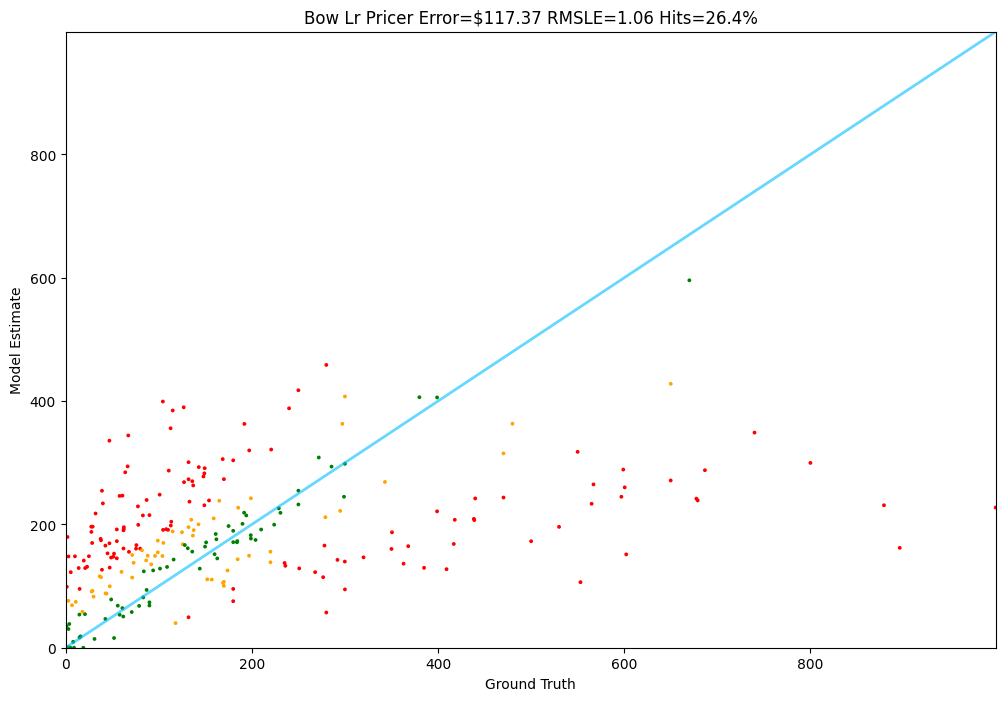

In [39]:
# test it

Tester.test(bow_lr_pricer)

In [40]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [41]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [42]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [43]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $164.97 Truth: $51.18 Error: $113.79 SLE: 1.34 Item: Nadair 22" LED Under Cabinet Lighting Ki...
2: Guess: $139.58 Truth: $319.99 Error: $180.41 SLE: 0.68 Item: Touch of Class Piala Pineapple Table Lam...
3: Guess: $81.90 Truth: $137.54 Error: $55.64 SLE: 0.26 Item: Legrand - OnQ Desk Mount Power Supply, P...
4: Guess: $255.53 Truth: $470.33 Error: $214.80 SLE: 0.37 Item: Moen TS44503BG Colinet Two Deck-Mount Ro...
5: Guess: $235.80 Truth: $57.97 Error: $177.83 SLE: 1.93 Item: ShowerMaxx, Elite Series, 6 Spray Settin...
6: Guess: $83.05 Truth: $28.77 Error: $54.28 SLE: 1.08 Item: Cenipar WD08X10057 Dishwasher Door Gaske...
7: Guess: $45.24 Truth: $14.90 Error: $30.34 SLE: 1.14 Item: Belkin 15.4-Inch Neoprene Sleeve (Black/...
8: Guess: $299.38 Truth: $224.00 Error: $75.38 SLE: 0.08 Item: TOTO UT447E#01 Commercial Washout Urinal...
9: Guess: $216.92 Truth: $29.00 Error: $187.92 SLE: 3.93 Item: DC Programmable Meter Controller 0-200V ...
10: Guess: $138.86 Truth: $144.08 Error:

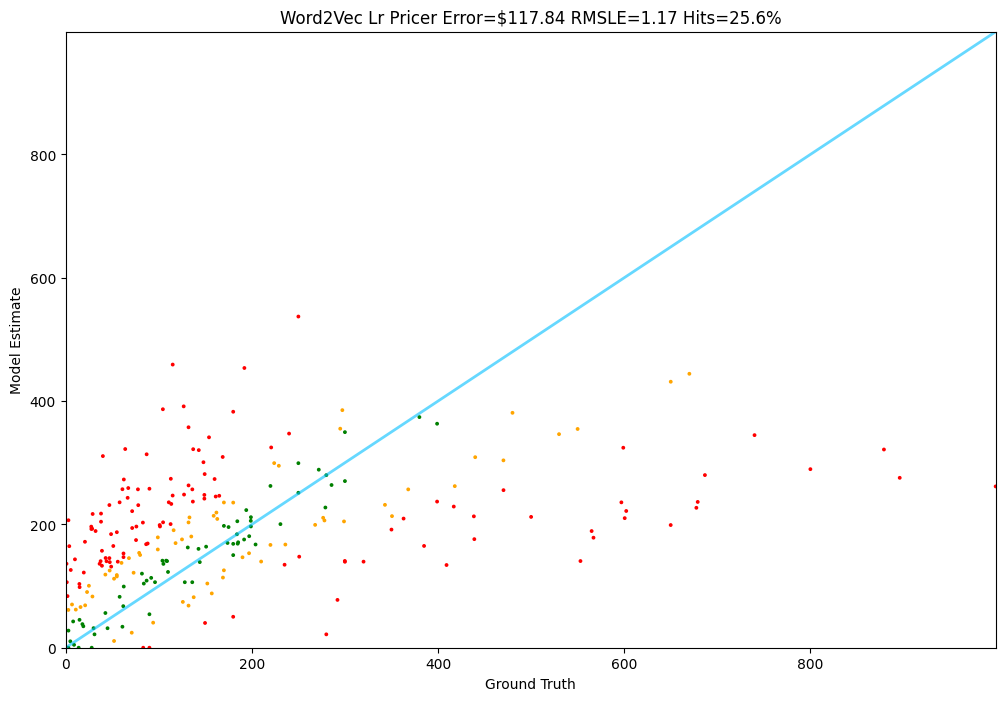

In [44]:
Tester.test(word2vec_lr_pricer)

In [45]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [46]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $105.47 Truth: $51.18 Error: $54.29 SLE: 0.51 Item: Nadair 22" LED Under Cabinet Lighting Ki...
2: Guess: $117.96 Truth: $319.99 Error: $202.03 SLE: 0.99 Item: Touch of Class Piala Pineapple Table Lam...
3: Guess: $84.42 Truth: $137.54 Error: $53.12 SLE: 0.23 Item: Legrand - OnQ Desk Mount Power Supply, P...
4: Guess: $169.50 Truth: $470.33 Error: $300.83 SLE: 1.03 Item: Moen TS44503BG Colinet Two Deck-Mount Ro...
5: Guess: $201.30 Truth: $57.97 Error: $143.33 SLE: 1.52 Item: ShowerMaxx, Elite Series, 6 Spray Settin...
6: Guess: $33.46 Truth: $28.77 Error: $4.69 SLE: 0.02 Item: Cenipar WD08X10057 Dishwasher Door Gaske...
7: Guess: $29.23 Truth: $14.90 Error: $14.33 SLE: 0.41 Item: Belkin 15.4-Inch Neoprene Sleeve (Black/...
8: Guess: $221.42 Truth: $224.00 Error: $2.58 SLE: 0.00 Item: TOTO UT447E#01 Commercial Washout Urinal...
9: Guess: $137.82 Truth: $29.00 Error: $108.82 SLE: 2.35 Item: DC Programmable Meter Controller 0-200V ...
10: Guess: $92.39 Truth: $144.08 Error: $51

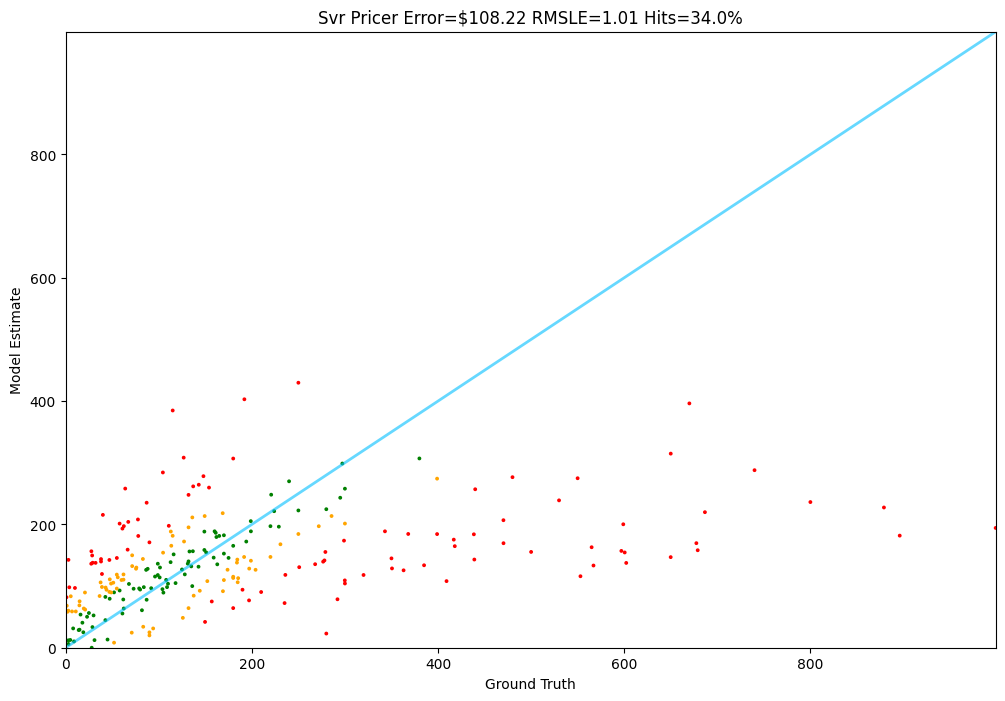

In [47]:
Tester.test(svr_pricer)

In [48]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [49]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $97.20 Truth: $51.18 Error: $46.02 SLE: 0.40 Item: Nadair 22" LED Under Cabinet Lighting Ki...
2: Guess: $140.36 Truth: $319.99 Error: $179.63 SLE: 0.67 Item: Touch of Class Piala Pineapple Table Lam...
3: Guess: $103.05 Truth: $137.54 Error: $34.49 SLE: 0.08 Item: Legrand - OnQ Desk Mount Power Supply, P...
4: Guess: $344.97 Truth: $470.33 Error: $125.36 SLE: 0.10 Item: Moen TS44503BG Colinet Two Deck-Mount Ro...
5: Guess: $124.35 Truth: $57.97 Error: $66.38 SLE: 0.57 Item: ShowerMaxx, Elite Series, 6 Spray Settin...
6: Guess: $135.10 Truth: $28.77 Error: $106.33 SLE: 2.31 Item: Cenipar WD08X10057 Dishwasher Door Gaske...
7: Guess: $54.93 Truth: $14.90 Error: $40.03 SLE: 1.58 Item: Belkin 15.4-Inch Neoprene Sleeve (Black/...
8: Guess: $252.40 Truth: $224.00 Error: $28.40 SLE: 0.01 Item: TOTO UT447E#01 Commercial Washout Urinal...
9: Guess: $170.02 Truth: $29.00 Error: $141.02 SLE: 3.03 Item: DC Programmable Meter Controller 0-200V ...
10: Guess: $83.68 Truth: $144.08 Error: 

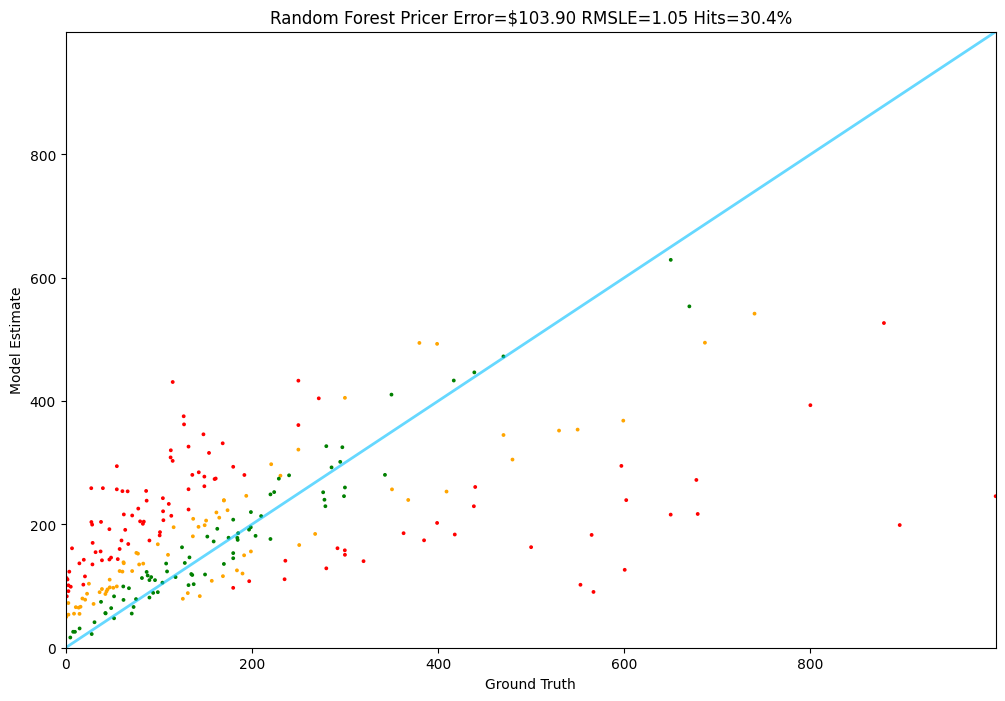

In [50]:
Tester.test(random_forest_pricer)